# 事前準備

In [1]:
# 各種ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
# MNISTデータ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(X_test.shape)
print(X_train[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [3]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# チャネル軸を増やす
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]

# 正解ラベル（0から9の整数）をone-hot表現に変換する
enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.fit_transform(y_test[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

# データを分割する
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(60000,)
(60000, 10)
float64
(48000, 1, 28, 28)
(12000, 1, 28, 28)
(48000, 10)
(12000, 10)


# 【問題1】2次元畳み込み層の作成

1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。  
フォワードプロパゲーションの数式は以下のようになります。  
$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$
$a_{i,j,m}$ : 出力される配列のi行j列、mチャンネルの値  
$i$ : 配列の行方向のインデックス  
$j$ : 配列の列方向のインデックス  
$m$ : 出力チャンネルのインデックス  
$K$ : 入力チャンネル数  
$F_{h}, F_{w}$ : 高さ方向（h）と幅方向（w）のフィルタのサイズ  
$x_{(i+s),(j+t),k}$ : 入力の配列の(i+s)行(j+t)列、kチャンネルの値  
$w_{s,t,k,m}$ : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み  
$b_m$ : mチャンネルへの出力のバイアス項  
全てスカラーです。  
次に更新式です。1次元畳み込み層や全結合層と同じ形です。  
$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$
$\alpha$ : 学習率  
$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$ に関する損失 $L$ の勾配  
$\frac{\partial L}{\partial b_{m}}$ : $b_{m}$ に関する損失 $L$ の勾配  
勾配 $\frac{\partial L}{\partial w_{s,t,k,m}}$ や $\frac{\partial L}{\partial b_{m}}$ を求めるためのバックプロパゲーションの数式が以下である。  
$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$
$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi行j列、mチャンネルの値  
$N_{out,h},N_{out,w}$ : 高さ方向（h）と幅方向（w）の出力のサイズ  
前の層に流す誤差の数式は以下です。 
$$
\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}
$$
$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列のi列j行、kチャンネルの値  
$M$ : 出力チャンネル数  
ただし、 $i-s<0$ または $i-s>N_{out,h}-1$ または $j-t<0$ または $j-t>N_{out,w}-1$ のとき $\frac{\partial L}{\partial a_{(i-s),(j-t),m}} =0$ です。

In [4]:
class HeInitializerForConv2d:
    """Xavierの初期値"""
    def W(self, IH, IW, FH, FW, IC, OC):
        """重みの初期化
        :parameters
            IH (int): 入力データの高さ
            IW (int): 入力データの幅
            FH (int): フィルターの高さ
            FW (int): フィルターの横幅
            IC (int): 入力チャンネル数
            OC (int): 出力チャンネル数（フィルター数）
        :returns
            W (4d-array, (OC, IC, FH, FW)): ランダムに発生させた重み
        """
        return np.sqrt(2.0 / (IC*IH*IW)) * np.random.randn(OC, IC, FH, FW)
    
    def B(self, IH, IW, IC, OC):
        """バイアスの初期化
        :parameters
            IH (int): 入力サイズ縦
            IW (int): 入力サイズ横
            OC (int): 出力チャンネル数（フィルター数）
        :returns
            B (1d-array, (OC,)): ランダムに発生させたバイアス
        """
        return np.sqrt(2.0 / (IC*IH*IW)) * np.random.randn(OC)

In [5]:
class SGD:
    """確率的勾配降下法
    :parameters
        lr (float): 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, layer):
        """ある層の重みやバイアスを更新する
        :parameters
            layer (instance): 更新前の層（FC）のインスタンス
        """
        layer.W -= self.lr * layer.dW / layer.N
        layer.B -= self.lr * layer.dB / layer.N
        return layer

In [6]:
class Conv2d:
    """2次元畳み込み
    :parameters
        IH, IW (int): 入力サイズ（特徴量の数）
        IC (int): 入力チャンネル数（色の次元の数？）
        OC (int): 出力チャンネル数（フィルター枚数）
        FH, FW (tuple, (2,)): フィルター（重み）サイズ（縦、横）
        SH, SW (tuple, (2,)): ストライド（縦、横）
        PH, PW (tuple, (2,)): パディング（縦、横）
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, OC, F, S=(1, 1), P=(0, 0), initializer=HeInitializerForConv2d(), optimizer=SGD()):
        # 重み初期化方法・最適化手法
        self.initializer = initializer
        self.optimizer = optimizer
        # フィルター形状・畳み込みの方法（stride, padding）などを取得
        self.OC = OC
        self.FH, self.FW = F
        self.SH, self.SW = S
        self.PH, self.PW = P
        # 重みとバイアス
        self.W = None
        self.B = None
        self.is_first_forward = True
    
    def forward(self, X):
        """順伝播
        :parameters
            X (4d-array, (N, IC, IH, IW)): 入力画像
        :returns
            A (4d-array, (N, OC, OH, OW)): 出力画像
        """
        # データ数・形状等の取得
        # OC, F, S, Pはインスタンス化した時に取得済み
        self.N, self.IC, self.IH, self.IW = X.shape
        self.OH, self.OW = self.calc_output_size()  # 出力サイズ（出力特徴量数）
        
        # selfを書くのめんどくさいので、、、
        N = self.N
        FH, FW = self.FH, self.FW
        SH, SW = self.SH, self.SW
        PH, PW = self.PH, self.PW
        IC, IH, IW = self.IC, self.IH, self.IW
        OC, OH, OW = self.OC, self.OH, self.OW
        
        # パディング
        self.X = X.copy()
        X = np.pad(X, [(0, 0), (0, 0), (PH, PH), (PW, PW)], "constant")

        # 重みとバイアスの初期化
        if self.is_first_forward:
            self.W = self.initializer.W(IH, IW, FH, FW, IC, OC)
            self.B = self.initializer.B(IH, IW, IC, OC)
            self.is_first_forward = False
        W, B = self.W, self.B
        
        # 畳み込み： A = X(*)W + Bを計算する
        A = np.zeros((N, OC, OH, OW))  # 出力格納用
        for oh in range(OH):
            h = oh * SH
            for ow in range(OW):
                w = ow * SW
                # 縦と横に１つずつずらしながら、アダマール積して合計する
                # X(N, IC, IH, IW)のうち、スライスでサイズ (FH x FW) だけ取得する。 --> X[](N, IC, FH, FW)
                # X[](N, IC, FH, FW)と、W(OC, IC, FH, FW)のアダマール積を計算するが、
                # このとき、XをOC方向にブロードキャストしたいので、newaxisで X(N, 1, IC, FH, FW)とする。
                # これで、XW(N, OC, IC, FH, FW)になる。
                XW = X[:, np.newaxis, :, h:h+FH, w:w+FW] * W

                # XWを(IC, FH, FW)方向に合計するので、np.sum(XW, axis=(2, 3, 4))
                # その結果、sumXW(N, OC)となる。
                sumXW = np.sum(XW, axis=(2, 3, 4))
                
                # sumXW(N, OC)とB(OC,)との和をとる。
                # Bが、sumXWのN方向にブロードキャストされて、
                # 結果、A(N, OC)となる。
                A[:, :, oh, ow] = sumXW + B
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (4d-array, (N, OC, OH, OW)): 出力の勾配
        :returns
            dX (4d-array, (N, IC, IH, IW)): 入力の勾配
        :returns
        """
        # selfを書くのめんどくさいので、、、
        X, W, B = self.X, self.W, self.B
        N = self.N
        FH, FW = self.FH, self.FW
        SH, SW = self.SH, self.SW
        PH, PW = self.PH, self.PW
        IC, IH, IW = self.IC, self.IH, self.IW
        OC, OH, OW = self.OC, self.OH, self.OW
        
        # ===== dB(OC,)を求める =====
        # dA(N, OC, OH, OW)を (N, OH, OW)方向に合計する。
        self.dB = np.sum(dA, axis=(0, 2, 3))
        
        # ===== dW(OC, IC, FH, FW)を求める =====
        # X(N, IC, IH, IW) x dA(N, OC, OH, OW) --> dW(OC, IC, FH, FW)にしたい。
        self.dW = np.zeros((OC, IC, FH, FW))
        for fh in range(FH):
            for fw in range(FW):
                # Xをstart-stopまでをストライドのstepでスライスする。
                # Xをスライスして、   X[](N, IC, 1, OH, OW)
                # dAの軸を増やして、  dA(N, 1, OC, OH, OW)
                # お互いにブロードキャストしながらアダマール積すると、
                # XdA(N, IC, OC, OH, OW)となる。
                #print(dA[:, np.newaxis, ...].shape)
                #print(X[:, :, np.newaxis, fh:fh+OH*SH:SH, fw:fw+OW*SW:SW].shape)
                XdA = X[:, :, np.newaxis, fh:fh+OH*SH:SH, fw:fw+OW*SW:SW] * dA[:, np.newaxis, ...]

                # XdAを (N, OH, OW)方向に合計すると、sumXdA(IC, OC)となる。
                sumXdA = np.sum(XdA, axis=(0, 3, 4)) 

                # dW(OC, IC, FH, FW)から格納する位置を指定する。dW[](OC, IC)
                # sumXdA(IC, OC)を転置して、(OC, IC)にする。
                self.dW[:, :, fh, fw] = sumXdA.T
        
        # ===== dX(N, IC, IH, IW)を求める =====
        # 最初に、W(OC, IC, FH, FW)から、
        # tile_W(IC, OC, OH, OW, IH+2PH, IW+2PW)を作る。
        # ストライドずつずらしながら、Wをタイルする。
        tile_W = np.zeros((IC, OC, OH, OW, IH+2*PH, IW+2*PW))
        for oh in range(OH):
            h = oh * SH
            for ow in range(OW):
                w = ow * SW
                # W(OC, IC, FH, FW) --> W(IC, OC, FH, FW)に転置して代入
                tile_W[:, :, oh, ow, h:h+FH, w:w+FW] = W.transpose(1, 0, 2, 3)

        # dA(N, OC, OH, OW)を tile_W(IC, OC, OH, OW, IH+2PH, IW+2PW) と積和する
        # dA     (N, 1,  OC, OH, OW,      1,      1)
        # tile_W (1, IC, OC, OH, OW, IH+2PH, IW+2PW)
        # アダマール積すると、
        # dAW    (N, IC, OC, OH, OW, IH+2PH, IW+2PW)
        dAW = dA[:, np.newaxis, ..., np.newaxis, np.newaxis] * tile_W[np.newaxis, ...]
        
        # dX(N, IC, IH, IW)にするため、
        # dAWを(OC, OH, OW)方向に合計する
        dX = np.sum(dAW, axis=(2, 3, 4))
        
        # 現在のdX(N, IC, IH+2PH, IW+2PW)
        # パディングした部分を削除して、dX(N, IC, IH, IW)にする
        if PH > 0:
            dX = dX[:, :, PH:-PH, :]
        if PW > 0:
            dX = dX[:, :, :, PW:-PW]
        
        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

    def calc_output_size(self):
        OH = (self.IH + 2*self.PH - self.FH) // self.SH + 1
        OW = (self.IW + 2*self.PW - self.FW) // self.SW + 1
        return (OH, OW)

In [7]:
print("Generate Instance")
cnn = Conv2d(OC=10, F=(3, 3))
print(type(cnn))

print("\n=====Forward")
print("X", X_train[:5].shape)
a = cnn.forward(X_train[:5])
print("A", a.shape)
      
print("\n=====Backward")
da = np.ones_like(a)
print("dA", da.shape)
dx = cnn.backward(da)
print("dX", dx.shape)

Generate Instance
<class '__main__.Conv2d'>

=====Forward
X (5, 1, 28, 28)
A (5, 10, 26, 26)

=====Backward
dA (5, 10, 26, 26)
dX (5, 1, 28, 28)


# 【問題2】2次元畳み込み後の出力サイズ

畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。  
この計算を行う関数を作成してください。  
$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$
$N_{out}$ : 出力のサイズ（特徴量の数）  
$N_{in}$ : 入力のサイズ（特徴量の数）  
$P$ : ある方向へのパディングの数  
$F$ : フィルタのサイズ  
$S$ : ストライドのサイズ  
$h$ が高さ方向、 $w$ が幅方向である

In [8]:
def calc_output_size(self):
        Nout_h = (self.IH + 2*self.PH - self.FH) // self.SH + 1
        Nout_w = (self.IW + 2*self.PW - self.FW) // self.SW + 1
        return (Nout_h, Nout_w)

# 【問題3】最大プーリング層の作成

最大プーリング層のクラスMaxPool2Dを作成してください。  
プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。
$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$
$P_{i,j}$ : i行j列への出力する場合の入力配列のインデックスの集合。 $S_{h}×S_{w}$ の範囲内の行（p）と列（q）  
$S_{h}, S_{w}$ : 高さ方向（h）と幅方向（w）のストライドのサイズ  
$(p,q)\in P_{i,j}$ : $P_{i,j}$ に含まれる行（p）と列（q）のインデックス  
$a_{i,j,m}$ : 出力される配列のi行j列、kチャンネルの値  
$x_{p,q,k}$ : 入力の配列のp行q列、kチャンネルの値  
ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。  
バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス $(p,q)$ を保持しておく必要があります。  
フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [9]:
class MaxPool2d:
    """Max Pooling Layer
    :parameters
        F (tuple, (2,)): フィルターサイズ（縦、横）
        S (tuple, (2,)): ストライド（縦、横）
        P (tuple, (2,)): パディング（縦、横
    """
    def __init__(self, F, S=(1, 1), P=(0, 0)):
        # フィルター形状・畳み込みの方法（stride, padding）などを取得
        self.FH, self.FW = F
        self.SH, self.SW = S
        self.PH, self.PW = P
    
    def forward(self, Z):
        """
        :parameters
            Z (4d-array, (N, IC, IH, IW)): 畳み込み層からの出力を受け取る（ReLUを通したあと）
        :returns
            V (4d-array, (N, OC, OH, OW)): サイズが縮小した出力(OC = IC)
        """
        # 形状を取得
        self.N, self.IC, self.IH, self.IW = Z.shape
        self.OH, self.OW = self.calc_output_size()
        self.OC = self.IC  # Poolingではチャネル数は変わらないので OC = IC
        
        # self省略
        N = self.N
        FH, FW = self.FH, self.FW
        SH, SW = self.SH, self.SW
        PH, PW = self.PH, self.PW
        IC, IH, IW = self.IC, self.IH, self.IW
        OC, OH, OW = self.OC, self.OH, self.OW

        # パディング
        self.Z = np.pad(Z, [(0, 0), (0, 0), (PH, PH), (PW, PW)], "constant")

        # im2col
        img = self.Z  # Z(N, IC, IH, IW)
        col = np.zeros((N, OC, FH, FW, OH, OW))
        for fh in range(FH):
            for fw in range(FW):
                col[:, :, fh, fw, :, :] = img[:, :, fh:fh+SH*OH:SH, fw:fw+SW*OW:SW]
        # col(N, OC, FH, FW, OH, OW) --> transpose （軸の途中でreshapeしないように軸の順番を入れ替える）
        # col(N, OH, OW, OC, FH, FW) --> reshape 軸圧縮(前の４軸, 後の２軸)
        # col(N*OH*OW*OC, FH*FW)
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*OH*OW*OC, FH*FW)

        # (FH*FW)方向の最大値と最大値のインデックス
        V = np.max(col, axis=1)  # (N*OH*OW*OC,) ベクトル
        self.idx = np.argmax(col, axis=1)  # (N*OH*OW*OC,) ベクトル
        
        # (N*OH*OW*OC,) ベクトル
        # (N, OH, OW, OC) 4次元配列
        # (N, OC, OH, OW) 転置
        V = V.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2)
        return V
        
    def backward(self, dV):
        """
        :parameters
            dV (4d-array, (N, OC, OH, OW)): 損失関数の出力方向における勾配（∂L/∂V）
        :returns
            dZ (4d-array, (N, IC, IH, IW)): 損失関数の入力方向における勾配（∂L/∂Z）
        """
        # self省略
        N = self.N
        FH, FW = self.FH, self.FW
        SH, SW = self.SH, self.SW
        PH, PW = self.PH, self.PW
        IC, IH, IW = self.IC, self.IH, self.IW
        OC, OH, OW = self.OC, self.OH, self.OW
        
        # colと同じ形状の行列を作る(N*OH*OW*IC, FH*FW)
        dcol = np.zeros((N*OH*OW*OC, FH*FW))

        # dV.ravel(N*OH*OW*OC,)のベクトルを
        # dcolの中の、max_idxのところにｄVを代入していく
        dV = dV.transpose(0, 2, 3, 1)  # (N, OH, OW, OC)
        dcol[np.arange(N*OH*OW*OC), self.idx] = dV.ravel()
        
        # col2im
        # dcol(N*OH*OW*OC, FH*FW) --> reshape 軸展開 (N, OH, OW, OC, FH, FW)
        # dcol(N, OH,     OW,     OC, FH, FW) --> transpose
        # dcol(N, OC,     FH,     FW, OH, OW)
        # img (N, IC, IH+2PH, IW+2PW)
        dcol = dcol.reshape(N, OH, OW, OC, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, IC, IH+2*PH, IW+2*PW))
        for fh in range(FH):
            for fw in range(FW):
                img[:, :, fh:fh+SH*OH:SH, fw:fw+SW*OW:SW] += dcol[:, :, fh, fw, :, :]
        
        # パディングした部分を削除
        if PH > 0:
            img = img[:, :, PH:-PH, :]
        if PW > 0:
            img = img[:, :, :, PW:-PW]
        
        dZ = img
        return dZ
        
    def calc_output_size(self):
        OH = (self.IH + 2*self.PH - self.FH) // self.SH + 1
        OW = (self.IW + 2*self.PW - self.FW) // self.SW + 1
        return (OH, OW)

In [10]:
print("Generate Instance")
maxpool = MaxPool2d(F=(10, 10))
print(type(maxpool))

print("\n=====forward")
print("Z", X_train[:5].shape)
v = maxpool.forward(X_train[:5])
print("V", v.shape)

print("\n=====backward")
dv = np.ones_like(v)
print("dV", dv.shape)
dz = maxpool.backward(dv)
print("dZ", dz.shape)

Generate Instance
<class '__main__.MaxPool2d'>

=====forward
Z (5, 1, 28, 28)
V (5, 1, 19, 19)

=====backward
dV (5, 1, 19, 19)
dZ (5, 1, 28, 28)


# 【問題4】平均プーリングの作成

平均プーリング層のクラスAveragePool2Dを作成してください。  
範囲内の最大値ではなく、平均値を出力とするプーリング層です。  
画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [11]:
class AvePool2d:
    """Average Pooling Layer
    :parameters
        F (tuple, (2,)): フィルターサイズ（縦、横）
        S (tuple, (2,)): ストライド（縦、横）
        P (tuple, (2,)): パディング（縦、横
    """
    def __init__(self, F, S=(1, 1), P=(0, 0)):
        # フィルター形状・畳み込みの方法（stride, padding）などを取得
        self.FH, self.FW = F
        self.SH, self.SW = S
        self.PH, self.PW = P
    
    def forward(self, Z):
        """
        :parameters
            Z (4d-array, (N, IC, IH, IW)): 畳み込み層からの出力を受け取る（ReLUを通したあと）
        :returns
            V (4d-array, (N, OC, OH, OW)): サイズが縮小した出力(OC = IC)
        """
        # 形状を取得
        self.N, self.IC, self.IH, self.IW = Z.shape
        self.OH, self.OW = self.calc_output_size()
        self.OC = self.IC  # Poolingではチャネル数は変わらないので OC = IC
        
        # self省略
        N = self.N
        FH, FW = self.FH, self.FW
        SH, SW = self.SH, self.SW
        PH, PW = self.PH, self.PW
        IC, IH, IW = self.IC, self.IH, self.IW
        OC, OH, OW = self.OC, self.OH, self.OW

        # パディング
        self.Z = np.pad(Z, [(0, 0), (0, 0), (PH, PH), (PW, PW)], "constant")

        # im2col
        img = self.Z  # Z(N, IC, IH, IW)
        col = np.zeros((N, OC, FH, FW, OH, OW))
        for fh in range(FH):
            for fw in range(FW):
                col[:, :, fh, fw, :, :] = img[:, :, fh:fh+SH*OH:SH, fw:fw+SW*OW:SW]
        # col(N, OC, FH, FW, OH, OW) --> transpose （軸の途中でreshapeしないように軸の順番を入れ替える）
        # col(N, OH, OW, OC, FH, FW) --> reshape 軸圧縮(前の４軸, 後の２軸)
        # col(N*OH*OW*OC, FH*FW)
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*OH*OW*OC, FH*FW)

        # 平均値を求める
        V = np.mean(col, axis=1)  # (N*OH*OW*OC,) ベクトル
        
        # (N*OH*OW*OC,) ベクトル
        # (N, OH, OW, OC) 4次元配列
        # (N, OC, OH, OW) 転置
        V = V.reshape(N, OH, OW, OC).transpose(0, 3, 1, 2)
        return V
        
    def backward(self, dV):
        """
        :parameters
            dV (4d-array, (N, OC, OH, OW)): 損失関数の出力方向における勾配（∂L/∂V）
        :returns
            dZ (4d-array, (N, IC, IH, IW)): 損失関数の入力方向における勾配（∂L/∂Z）
        """
        # self省略
        N = self.N
        FH, FW = self.FH, self.FW
        SH, SW = self.SH, self.SW
        PH, PW = self.PH, self.PW
        IC, IH, IW = self.IC, self.IH, self.IW
        OC, OH, OW = self.OC, self.OH, self.OW
        
        # colと同じ形状の行列を作る(N*OH*OW*IC, FH*FW)
        dcol = np.zeros((N*OH*OW*OC, FH*FW))

        # dV.flatten(N*OH*OW*OC,)のベクトルを
        # dcolの中の、max_idxのところにｄVを代入していく
        dV = dV.transpose(0, 2, 3, 1)  # (N, OH, OW, OC)
        dcol[np.arange(N*OH*OW*OC), np.zeros(N*OH*OW*OC).astype(int)] = dV.ravel()
        
        # col2im
        # dcol(N*OH*OW*OC, FH*FW) --> reshape 軸展開 (N, OH, OW, OC, FH, FW)
        # dcol(N, OH,     OW,     OC, FH, FW) --> transpose
        # dcol(N, OC,     FH,     FW, OH, OW)
        # img (N, IC, IH+2PH, IW+2PW)
        dcol = dcol.reshape(N, OH, OW, OC, FH, FW).transpose(0, 3, 4, 5, 1, 2)
        img = np.zeros((N, IC, IH+2*PH, IW+2*PW))
        for fh in range(FH):
            for fw in range(FW):
                img[:, :, fh:fh+SH*OH:SH, fw:fw+SW*OW:SW] += dcol[:, :, fh, fw, :, :]
        img /= FH*FW  # 平均する
        
        # パディングした部分を削除
        if PH > 0:
            img = img[:, :, PH:-PH, :]
        if PW > 0:
            img = img[:, :, :, PW:-PW]
        
        dZ = img
        return dZ
        
    def calc_output_size(self):
        OH = (self.IH + 2*self.PH - self.FH) // self.SH + 1
        OW = (self.IW + 2*self.PW - self.FW) // self.SW + 1
        return (OH, OW)

In [12]:
print("Generate Instance")
avepool = AvePool2d(F=(10, 10))
print(type(avepool))

print("\n=====forward")
print("Z", X_train[:5].shape)
v = avepool.forward(X_train[:5])
print("V", v.shape)

print("\n=====backward")
dv = np.ones_like(v)
print("dV", dv.shape)
dz = avepool.backward(dv)
print("dZ", dz.shape)

Generate Instance
<class '__main__.AvePool2d'>

=====forward
Z (5, 1, 28, 28)
V (5, 1, 19, 19)

=====backward
dV (5, 1, 19, 19)
dZ (5, 1, 28, 28)


# 【問題5】平滑化

平滑化するためのFlattenクラスを作成してください。  
フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。  
その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。  
この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [13]:
class Flatten:
    def forward(self, img):
        """Imageを1次元Columnに変換
        :parameters
            img (4d-array, (N, IC, IH, IW))
        :returns
            col (2d-array, (N, IC*IH*IW))
        """
        self.im_shape = img.shape
        N, IC, IH, IW = self.im_shape
        col = img.reshape(N, IC*IH*IW)
        return col
    
    def backward(self, col):
        """Columnを３次元Imageに変換
        :parameters
            col (2d-array, (N, IC*IH*IW))
        :returns
            img (4d-array, (N, IC, IH, IW))
        """
        img = col.reshape(self.im_shape)
        return img

# 【問題6】学習と推定

作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。  
精度は低くともまずは動くことを目指してください。

In [14]:
class GetMiniBatch:
    """ミニバッチを取得するイテレータ
    :parameters
        X (2d-array, (n_samples, n_features)): 訓練データ
        y (1d-array, (n_samples, 1)): 正解値
        batch_size (int): バッチサイズ
        seed (int): 乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [15]:
class ReLU:
    """rectified linear unit関数（活性化関数）"""
    def forward(self, A):
        self.is_positive = A > 0
        Z = self.is_positive * A
        return Z
    
    def backward(self, dZ):
        if dZ.shape == self.is_positive.shape:
            dA = self.is_positive * dZ
        else:
            dA = self.is_positive * dZ[:, np.newaxis, :]
        return dA

In [16]:
class Softmax:
    """softmax関数
    backwardは交差エントロピー誤差関数と合わせて計算する
    """
    def forward(self, A):
        y_pred = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
        # backward用にy_predを保持
        self.y_pred = y_pred
        return y_pred
    
    def backward(self, y_true):
        dA = self.y_pred - y_true
        return dA

In [17]:
class HeInitializerForAffine:
    """Heの初期値"""
    def W(self, n_nodes1, n_nodes2):
        """重みの初期化
        :parameters
            n_nodes1 (int): 前の層のノード数
            n_nodes2 (int): 後の層のノード数
        :returns
            W (2d-array, (n_nodes1, n_nodes2)): ランダムに発生させた重み
        """
        return np.sqrt(2.0 / n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes1, n_nodes2):
        """バイアスの初期化
        :parameters
            n_nodes2 (int): 後の層のノード数
        :returns
            B (1d-array, (n_nodes2, )): ランダムに発生させたバイアス
        """
        return np.sqrt(2.0 / n_nodes1) * np.random.randn(1, n_nodes2)

In [18]:
class FC:
    """ノード数n_nodes1からn_nodes2への全結合層
    :parameters
        n_node1 (int): 前層のノード数
        n_node2 (int): 後層のノード数
        initializer (class instance): 初期化方法のインスタンス
        optimizer (class instance): 最適化手法のインスタンス
    """
    def __init__(self, n_nodes2, initializer=HeInitializerForAffine(), optimizer=SGD()):
        self.initializer = initializer
        self.optimizer = optimizer
        self.n_nodes2 = n_nodes2
        self.is_first_forward = True
    
    def forward(self, X):
        """順伝播
        :parameters
            X (2d-array, (batch_size, n_nodes1)): 入力
        :returns
            A (2d-array, (batch_size, n_nodes2)): 出力
        """
        # チャネル数が残っているときは削除する
        if X.ndim > 2:
            X = np.squeeze(X, 1)

        # 形状取得
        n_nodes1 = X.shape[1]
        n_nodes2 = self.n_nodes2
        
        # 初めてforwardを実行するときは、重みとバイアスを初期化
        if self.is_first_forward:
            self.W = self.initializer.W(n_nodes1, n_nodes2)
            self.B = self.initializer.B(n_nodes1, n_nodes2)
            self.is_first_forward = False

        # 線形結合
        A = np.matmul(X, self.W) + self.B
        
        # backward用にXを保持
        self.X = X
        self.N = X.shape[0]
        return A
    
    def backward(self, dA):
        """逆伝播
        :parameters
            dA (2d-array, (batch_size, n_nodes2)): 後層から戻ってきた勾配
        :returns
            dZ (2d-array, (batch_size, n_nodes1)): 前層に送る勾配
        """
        self.dB = np.sum(dA, axis=0, keepdims=True)
        self.dW = np.matmul(self.X.T, dA)
        dX = np.matmul(dA, self.W.T)
        # 勾配をもとに重みとバイアスを更新
        self = self.optimizer.update(self)
        return dX

In [19]:
class CNN2dClassifier():
    """Convolution Neural Network Classifier
    :attributes
        layers (list of instances): 各層のインスタンスを並べたリスト
        n_epoch (int): 繰り返すエポック数
        batch_size (int): ミニバッチのデータ数
        plot_interval (int): 損失関数を記録する間隔
        epoch_interval (int): 何epochごとにprintするか
        loss (list): 損失関数の推移（訓練データ）
        lossval (list): 損失関数の推移（検証データ）
        verbose (bool): 学習過程を出力する場合はTrue
    """
    def __init__(self, layers, n_epoch=10, batch_size=20, plot_interval=1, verbose=True, epoch_interval=1):
        self.layers = layers
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.plot_interval = plot_interval
        self.epoch_interval = epoch_interval
        self.verbose = verbose
        self.loss = []
        self.loss_val = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        """ニューラルネットワーク分類器を学習する。
        :parameters
            X (2d-array, (n_samples, n_features)): 訓練データの特徴量
            y (2d-array, (n_samples, n_classes)): 訓練データの正解値（One-hot）
            X_val (2d-array, (n_samples, n_features)): 検証データの特徴量
            y_val (2d-array, (n_samples, n_classes)): 検証データの正解値（One-hot）
            optimizer (instance): 最適化手法のインスタンス
        """
        # データチェック
        self.n_features = X.shape[1]
        self.n_output = y.shape[1]

        # 学習
        for epoch in range(self.n_epoch):
            # エポックごとに乱数を変えて、ミニバッチを取得する
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size, seed=epoch)
            
            # ミニバッチごとに学習をすすめる。
            for mini_X_train, mini_y_train in get_mini_batch:
                # forward
                data = mini_X_train
                for layer in self.layers:
                    data = layer.forward(data)

                # backward
                grad = mini_y_train
                for layer in reversed(self.layers):
                    grad = layer.backward(grad)
                
            # 損失（交差エントロピー誤差）を計算して保持
            y_pred = self.predict_proba(X)  # 分類カテゴリーごとの確率を計算
            L = self.cross_entropy_error(y_pred, y)
            self.loss.append(L)
            # 検証データありの場合はそちらの損失も保持
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict_proba(X_val)  # 分類カテゴリーごとの確率を計算
                L_val = self.cross_entropy_error(y_pred_val, y_val)
                self.loss_val.append(L_val)

            # 学習過程の出力（エポックごと）
            if self.verbose and (epoch % self.epoch_interval == 0):
                str_loss = "Epoch" + str(epoch).rjust(4)
                str_loss += "\tLoss {:.5f}".format(self.loss[-1])
                if len(self.loss_val) != 0:
                    str_loss += "\tLoss_valid {:.5f}".format(self.loss_val[-1])
                print(str_loss)

    def cross_entropy_error(self, y_pred, y_true):
        """交差エントロピー誤差の計算
        :parameters
            y_true (2d-array, (n_samples, n_classes)): クラスの正解ラベル（one-hotなので0 or 1）
            y_pred (2d-array, (n_samples, n_classes)): クラス分類の予測確率（yと同じ形状）
        :returns
            cee (float): 交差エントロピー誤差
        """
        cee = -1/y_pred.shape[0] * np.sum(y_true * np.log(y_pred))
        return cee
    
    def predict_proba(self, X):
        """ニューラルネットワーク分類器を使い推定する。推定結果は確率のOne-hot表現。
        :parameters
            X (2d-array, (n_samples, n_features)): サンプルデータ
        :returns
            y_pred (2d-array, (n_samples, n_classes)): 推定確率
        """
        # forward
        data = X
        for layer in self.layers:
            data = layer.forward(data)
        y_pred = data
        return y_pred
    
    def predict(self, X):
        """ニューラルネットワーク分類器を使い推定する。
        :parameters
            X (2d-array, (n_samples, n_features)): サンプル
        :returns
            label (1d-array, (n_samples,)): 推定ラベル
        """
        probability = self.predict_proba(X)
        label = np.argmax(probability, axis=1)
        return label

In [20]:
def calc_accuracy(nn):
    print("Validation Data")
    y_pred = nn.predict(X_val)
    y_true = np.argmax(y_val, axis=1)
    print(y_pred.shape)
    acc = accuracy_score(y_true, y_pred)
    print("accuracy = {:.5f}".format(acc))

    print()
    print("Test Data")
    y_pred_test = nn.predict(X_test)
    y_true_test = y_test
    print(y_pred_test.shape)
    acc_test = accuracy_score(y_true_test, y_pred_test)
    print("accuracy = {:.5f}".format(acc_test))

def draw_loss(nn):
    fig, ax = plt.subplots(figsize=(5, 5))
    x1 = np.arange(len(nn.loss))
    y1 = nn.loss
    x2 = np.arange(len(nn.loss_val))
    y2 = nn.loss_val

    ax.plot(x1, y1, label="train", alpha=0.7)
    ax.plot(x2, y2, label="valid", alpha=0.7)

    ax.set_xlabel("Epoch", fontsize=20)
    ax.set_ylabel("Loss", fontsize=20)
    ax.set_yscale("log")
    ax.set_xlim(-1, nn.n_epoch + 1)
    ax.set_ylim(1e-4, 5)
    ax.legend(frameon=False)
    plt.show()


Epoch   0	Loss 0.41397	Loss_valid 0.40154
Epoch   5	Loss 0.17144	Loss_valid 0.18992
Epoch  10	Loss 0.14219	Loss_valid 0.19827
Epoch  15	Loss 0.06754	Loss_valid 0.13323
Epoch  20	Loss 0.03491	Loss_valid 0.11794
Epoch  25	Loss 0.02853	Loss_valid 0.12479
Epoch  30	Loss 0.01959	Loss_valid 0.13481
Epoch  35	Loss 0.00679	Loss_valid 0.12168
Epoch  40	Loss 0.00470	Loss_valid 0.12482
Epoch  45	Loss 0.00351	Loss_valid 0.12774
CPU times: user 3h 46min 11s, sys: 24min 15s, total: 4h 10min 26s
Wall time: 1h 9min 32s
Validation Data
(12000,)
accuracy = 0.97033

Test Data
(10000,)
accuracy = 0.96880


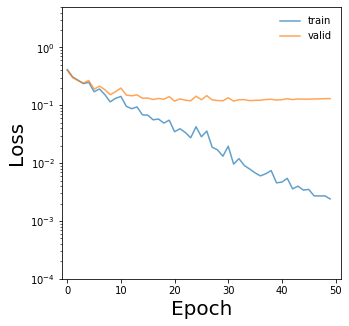

In [21]:
layers = [
    Conv2d(3, (3, 3)),
    ReLU(),
    MaxPool2d((3, 3)),
    Flatten(),
    FC(100),
    ReLU(),
    FC(y_train.shape[1]),
    Softmax(),
]

cnn = CNN2dClassifier(layers, n_epoch=50, epoch_interval=5)
%time cnn.fit(X_train[:10000], y_train[:10000], X_val, y_val)
calc_accuracy(cnn)
draw_loss(cnn)

# 【問題9】出力サイズとパラメータ数の計算

CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。  
また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。  
フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。  
以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

In [22]:
def out_size(H, W, P, FH, FW, S):
    out_h = (H + 2 * P - FH) // S + 1
    out_w = (W + 2 * P - FW) // S + 1
    return out_h, out_w

# フィルターの縦 * フィルターの横 * 入力のチャンネル数 * 出力のチャンネル数 + バイアス(1チャンネルごとに1つ)
def parm_n(FH, FW, C, FN):
    return FH*FW*C*FN + FN

1.  
- 入力サイズ : 144×144, 3チャンネル  
- フィルタサイズ : 3×3, 6チャンネル  
- ストライド : 1  
- パディング : なし

In [24]:
print(f'出力サイズ：{out_size(144, 144, 0, 3, 3, 1)}')
print(f'パラメータ数：{parm_n(3, 3, 3, 6)}')

出力サイズ：(142, 142)
パラメータ数：168


2.  
- 入力サイズ : 60×60, 24チャンネル  
- フィルタサイズ : 3×3, 48チャンネル  
- ストライド　: 1  
- パディング : なし

In [25]:
print(f'出力サイズ：{out_size(60, 60, 0, 3, 3, 1)}')
print(f'パラメータ数：{parm_n(3, 3, 24, 48)}')

出力サイズ：(58, 58)
パラメータ数：10416


3.  
- 入力サイズ : 20×20, 10チャンネル  
- フィルタサイズ: 3×3, 20チャンネル  
- ストライド : 2  
- パディング : なし

In [26]:
out_size(20, 20, 0, 3, 3, 2)
print(f'出力サイズ：{out_size(20, 20, 0, 3, 3, 2)}')
print(f'パラメータ数：{parm_n(3, 3, 10, 20)}')

出力サイズ：(9, 9)
パラメータ数：1820
